<a href="https://colab.research.google.com/github/rbb-99/time-series/blob/main/StockPricePredLSTM%26GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup dependencies

In [1]:
!mkdir ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 186MB/s]


In [5]:
!unzip stock-time-series-20050101-to-20171231.zip -d stocksdata

Archive:  stock-time-series-20050101-to-20171231.zip
  inflating: stocksdata/AABA_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/AAPL_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/AMZN_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/AXP_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/BA_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/CAT_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/CSCO_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/CVX_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/DIS_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/GE_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/GOOGL_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/GS_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/HD_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/IBM_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/INTC_2006-01-01_to_2018-01-01.csv  
  inflating: stocksdata/JNJ_2006-01-01_to_2018-01-01.csv  


We're using LSTMs for predicting the price of stocks of IBM for the year 2017

## Imports and utilities

In [6]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [8]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## EDA

In [9]:
# First, we get the data
dataset = pd.read_csv('./stocksdata/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [10]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

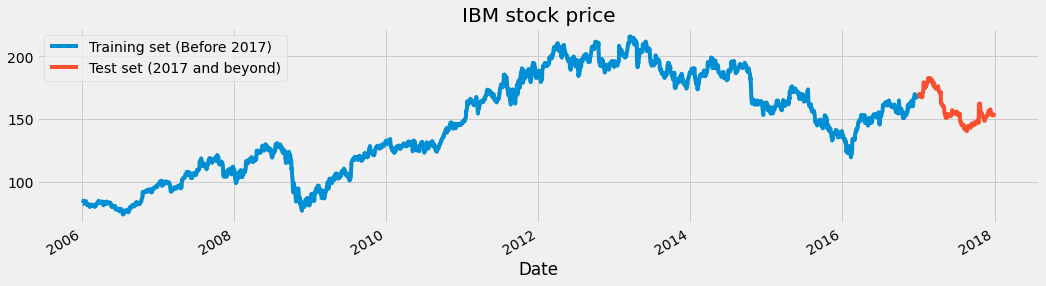

In [11]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [12]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [13]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [15]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 21s 144ms/step - loss: 0.0242
Epoch 2/50
85/85 [==============================] - 20s 235ms/step - loss: 0.0111
Epoch 3/50
85/85 [==============================] - 13s 157ms/step - loss: 0.0081
Epoch 4/50
85/85 [==============================] - 12s 144ms/step - loss: 0.0072
Epoch 5/50
85/85 [==============================] - 12s 144ms/step - loss: 0.0064
Epoch 6/50
85/85 [==============================] - 13s 149ms/step - loss: 0.0059
Epoch 7/50
85/85 [==============================] - 12s 145ms/step - loss: 0.0050
Epoch 8/50
85/85 [==============================] - 12s 144ms/step - loss: 0.0047
Epoch 9/50
85/85 [==============================] - 13s 150ms/step - loss: 0.0049
Epoch 10/50
85/85 [==============================] - 13s 153ms/step - loss: 0.0042
Epoch 11/50
85/85 [==============================] - 12s 145ms/step - loss: 0.0040
Epoch 12/50
85/85 [==============================] - 14s 162ms/step - loss: 0.0037
Epoch 13/50
8

In [16]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [17]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 37ms/step


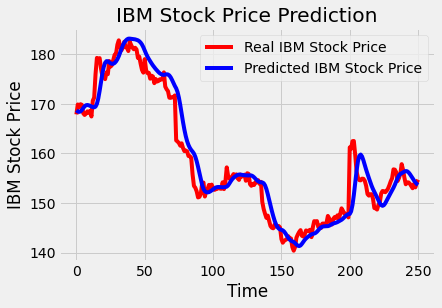

In [18]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [19]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 3.1950310495139957.


## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

In [20]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


19/19 [==============================] - 15s 342ms/step - loss: 0.1198
Epoch 2/50
19/19 [==============================] - 6s 313ms/step - loss: 0.0375
Epoch 3/50
19/19 [==============================] - 7s 355ms/step - loss: 0.0091
Epoch 4/50
19/19 [==============================] - 6s 311ms/step - loss: 0.0048
Epoch 5/50
19/19 [==============================] - 7s 352ms/step - loss: 0.0040
Epoch 6/50
19/19 [==============================] - 5s 273ms/step - loss: 0.0039
Epoch 7/50
19/19 [==============================] - 5s 288ms/step - loss: 0.0036
Epoch 8/50
19/19 [==============================] - 6s 312ms/step - loss: 0.0035
Epoch 9/50
19/19 [==============================] - 5s 277ms/step - loss: 0.0035
Epoch 10/50
19/19 [==============================] - 7s 355ms/step - loss: 0.0031
Epoch 11/50
19/19 [==============================] - 6s 311ms/step - loss: 0.0032
Epoch 12/50
19/19 [==============================] - 6s 339ms/step - loss: 0.0031
Epoch 13/50
19/19 [================

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [21]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 2s 52ms/step


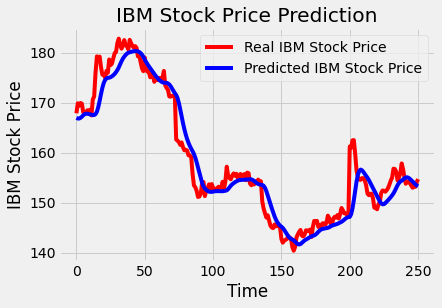

In [22]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [23]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 3.2317418115590746.
